# Basic cell for imports etc

In [ ]:
# TODO function calculate_weight(cov), which takes non-inverted cov
# then: remove Tscale parameter from build_covmatrices()
# then: move Tscaling of cov matrix into calculate_weight(cov)

import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json
import component_separation
from component_separation.io import IO
import healpy as hp
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw
import component_separation.transform_spec as trsf_s
from component_separation.cs_util import Config
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
csu = Config()
io = IO(csu)

# Helperfunctions

In [ ]:
def postprocess_spectrum(data, freqcomb, smoothing_window, max_polynom):
    if smoothing_window > 0 or max_polynom > 0:
        spec_sc = pw.smoothC_l(data, smoothing_window=smoothing_window, max_polynom=max_polynom)
    spec_sc = pw.apply_scale(data, scale=cf['pa']["Spectrum_scale"])
    beamf = io.load_beamf(freqcomb=freqcomb)
    spec_scbf = pw.apply_beamfunction(spec_sc, beamf, lmax, specfilter)
    return spec_scbf

def plt_std_powlog():
    plt.xlim((10,3000))
    plt.ylim((1e-6,1e1))
    plt.yscale('log')
    plt.xlabel("Multipole")
    plt.ylabel(r"Powerspectrum $C_l$")
    plt.legend()
    
def invert_covmatrices(cov, lmax: int):
    def maskit(a):
        """drops all row and columns with np.nan's.
        """
        masked = a[ ~np.isnan(a) ]
        mskd = masked.reshape(int(np.sqrt(len(masked))),int(np.sqrt(len(masked))))
        return mskd

    def is_invertible(a, l):
        truth = a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]
        if not truth:
            print('{} not invertible: {}'.format(l, a) )
        return truth

    def shp2cov_nan(shp):
        a = np.empty(shp)
        a[:] = np.nan
        return a

    def pad_shape(a):
        return ((7-a.shape[0],0),(7-a.shape[0],0))

    def pad_with(vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 0.0)
        vector[:pad_width[0]] = pad_value
        if pad_width[1] != 0:                      # <-- (0 indicates no padding)
            vector[-pad_width[1]:] = pad_value
    
    cov_inv_l = {
        spec: {
            l: np.pad(np.linalg.inv(maskit(cov[:,:,l])), pad_shape(maskit(cov[:,:,l])), pad_with)
            if is_invertible(maskit(cov[:,:,l]), l)
            else np.pad(shp2cov_nan(maskit(cov[:,:,l]).shape), pad_shape(maskit(cov[:,:,l])), pad_with)
                for l in range(lmax)
            }for spec in csu.PLANCKSPECTRUM_f
        }
    return cov_inv_l

def calculate_weights(cov, lmax: int, Tscale: str = "K_CMB") -> np.array:
    """Calculates weightings of the respective Frequency channels

    Args:
        cov (Dict): The inverted covariance matrices of Dimension [lmax,Nspec,Nspec]
        lmax (int): Maximum multipol of data to be considered
        freqfilter (List[str]): Frequency channels which are to be ignored
        specfilter (List[str]): Bispectra which are to be ignored, e.g. ["TT"]

    Returns:
        np.array: The weightings of the respective Frequency channels
    """
    
    def _elaw(shp):
        if Tscale == "K_RJ":
            return np.array([prep.tcmb2trj_sc(FREQ) for FREQ in csu.PLANCKMAPFREQ_f])
        else:
            return np.ones((shp))
    weight_arr = np.array([
            [(cov[spec][l] @ _elaw(cov[spec][l].shape[0])) / (_elaw(cov[spec][l].shape[0]).T @ cov[spec][l] @ _elaw(cov[spec][l].shape[0]))
                for l in range(lmax)]
        for spec in csu.PLANCKSPECTRUM_f])
    return weight_arr

def postprocess_spectrum(data, freqcomb, smoothing_window, max_polynom):
    if smoothing_window > 0 or max_polynom > 0:
        spec_sc = pw.smoothC_l(data, smoothing_window=smoothing_window, max_polynom=max_polynom)
    spec_sc = pw.apply_scale(data, scale=cf['pa']["Spectrum_scale"])
    beamf = io.load_beamf(freqcomb=freqcomb)
    spec_scbf = pw.apply_beamfunction(spec_sc, beamf, lmax, specfilter)
    return spec_scbf

In [3]:
cmbs4 = hp.read_alm("/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000//zb_terator_p_p_0000_nofg_OBD_solcond_3apr20/ffi_p_it12/blm_0012_b81c68c82af9fd6f9c742696b0a9df58ee3d3042_lmax2048.fits")
jcmbs4 = hp.read_alm("/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/lt_recons/08b.00_carron_210521_ilc_iter/blm_csMAP_obd_scond_lmaxcmb4000_iter_012_elm011_sim_0000.fits")

# CMB-S4

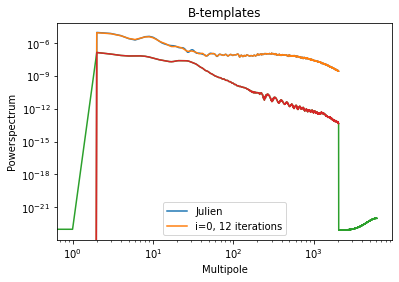

<ipython-input-10-20274ce4b2ab>:24: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(jcl/cl-1)


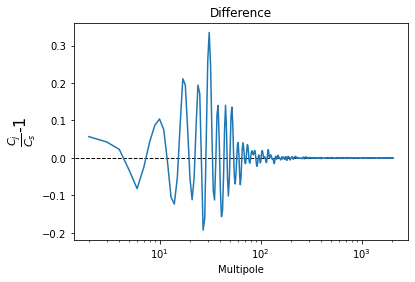

In [10]:
cl = hp.alm2cl(cmbs4)
jcl = hp.alm2cl(jcmbs4)

cjcl = hp.alm2cl(cmbs4-jcmbs4)

plt.title('B-templates')
plt.ylabel("Powerspectrum")
plt.xlabel('Multipole')
plt.plot(jcl, label="Julien")
plt.plot(cl, label="i=0, 12 iterations")
plt.plot(crosscl)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.plot(cjcl)
# plt.ylim((2e-8,1e-6))
# plt.xlim((1e1,1e2))
plt.show()

plt.title('Difference')
plt.ylabel(r"$\frac{C_j}{C_s}$-1", size=16)
plt.xlabel('Multipole')
plt.hlines(0,0,2000, color='black', ls='--', lw = 1)
plt.plot(jcl/cl-1)
# plt.xlim((1e1,1e2))
plt.xscale('log')

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


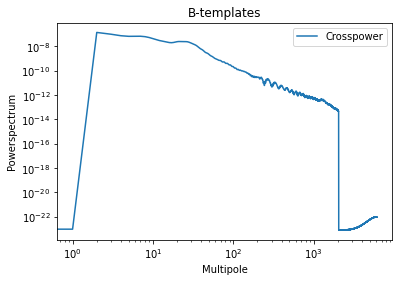

In [5]:
crosscl = hp.anafast(hp.alm2map(cmbs4, nside=2048)-hp.alm2map(jcmbs4, nside=2048))
plt.title('B-templates')
plt.ylabel("Powerspectrum")
plt.xlabel('Multipole')
plt.plot(crosscl, label="Crosspower")
plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.ylim((2e-8,1e-6))
# plt.xlim((1e1,1e2))
plt.show()

In [12]:
ml = hp.alm2map(cmbs4, nside=1024)
jml = hp.alm2map(jcmbs4, nside=1024)

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

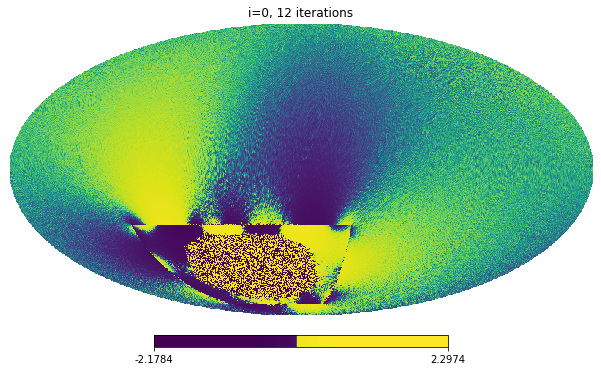

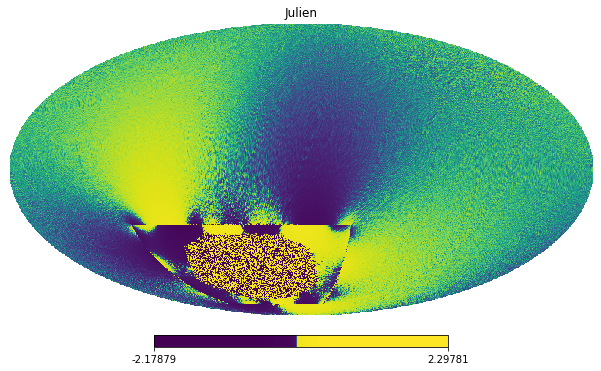

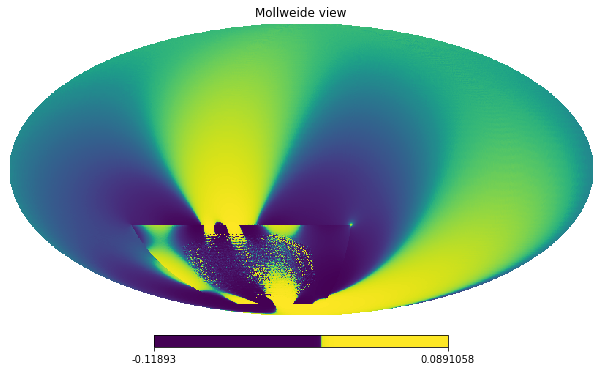

In [13]:
hp.mollview(ml, norm='hist', title='i=0, 12 iterations')
hp.mollview(jml, norm='hist', title='Julien')
hp.mollview(jml-ml, norm='hist')

# Load data and bin it
## Look at **low_ell** bins first

In [2]:
bins = const.SMICA_lowell_bins    #const.linear_equisized_bins_10
freqdset = cf['pa']['freqdset']
detector = [p.value for p in list(Planckf)]

ndet = 7
lmax = cf['pa']["lmax"]
lmax_mask = cf['pa']["lmax_mask"]
freqfilter = cf['pa']["freqfilter"]
specfilter = cf['pa']["specfilter"]
C_ltot = io.load_data(path_name=io.spec_sc_path_name)
cov_ltot = pw.build_covmatrices(C_ltot, lmax=lmax, freqfilter=freqfilter, specfilter=specfilter)["EE"]

C_lN_unsc = io.load_data(io.noise_unsc_path_name)
C_lN = postprocess_spectrum(C_lN_unsc, csu.freqcomb, cf['pa']['smoothing_window'], cf['pa']['max_polynom'])
cov_lN = pw.build_covmatrices(C_lN, lmax=lmax, freqfilter=freqfilter, specfilter=specfilter)

cov_ltot_bnd = hpf.bin_it(cov_ltot, bins=bins)
cov_lN_bnd = np.diagonal(hpf.bin_it(cov_lN["EE"], bins=bins), axis1=0, axis2=1).T

D_lS = pd.read_csv(
        cf[mch]['powspec_truthfile'],
        header=0,
        sep='    ',
        index_col=0)
D_lS_EE = D_lS["Planck-"+"EE"].to_numpy()
C_lS_EE = D_lS_EE[:lmax+1]/hpf.llp1e12(np.array([range(lmax+1)]))
cov_lS_EE = np.ones((ndet,ndet,lmax+1)) * C_lS_EE * 1e12
C_lS_bnd =  hpf.bin_it(cov_lS_EE, bins=bins)



cmb_in = io.load_data("/global/cscratch1/sd/sebibel/spectrum/NPIPE_sim_cmb/SPEC0200_C_l_NPIPE_sim_cmb_lens_3000_6000_0_0_Full.npy")

tf = io.load_data(cf[mch]['outdir_misc_ap']+"tf0200.npy")

smica_theta = io.load_data("/global/cscratch1/sd/sebibel/smica/theta.npy")
smica_cov4D = io.load_data("/global/cscratch1/sd/sebibel/smica/cov4D.npy")
smica_cov = io.load_data("/global/cscratch1/sd/sebibel/smica/cov.npy")
smica_cmb = io.load_data(io.out_specsmica_path + "CMB_" + io.specsmica_sc_filename
    )[0,0,:]

NameError: name 'const' is not defined

### Plot empiric data and noise

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Simulation data, NPIPE sim, CMB+FG+Noise')

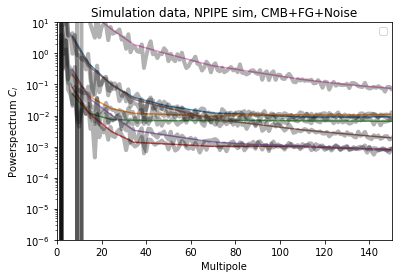

In [13]:
for n in range(0,7):
    if n < 3:
        plt.plot(np.mean(bins[:min(180,len(bins))],axis=1), cov_ltot_bnd[n,n,:min(180,len(bins))],alpha=0.8)
    else:
        plt.plot(np.mean(bins,axis=1), cov_ltot_bnd[n,n,:],alpha=0.8)
    plt.plot(cov_ltot[n,n,:-10],alpha=0.3, color='black',lw=4)
    
plt_std_powlog()
plt.xlim((0,150))
plt.title('Simulation data, NPIPE sim, CMB+FG+Noise')

# Plot smica cmb result, and planck best-EE estimate, as well as individual detector full spectra

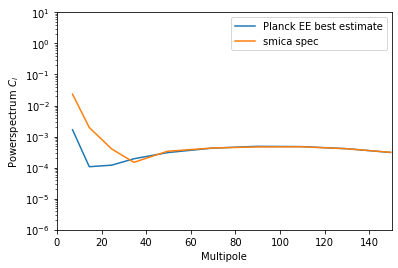

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Covariance Matrices')

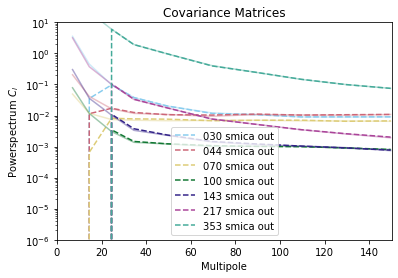

In [29]:
# %matplotlib widget
plt.plot(np.mean(bins,axis=1), C_lS_bnd[1,1,:], label="Planck EE best estimate")
plt.plot(np.mean(bins,axis=1), smica_cmb, label = 'smica spec')
plt_std_powlog()
plt.title('EE Planck best estimate vs Smica best estimate')
plt.xlim((0,150))
plt.show()

plt_std_powlog()
plt.xlim((0,150))
cov_ltotEE = cov_ltot[0:8,0:8,:]
cov_ltot_bnd = hpf.bin_it(cov_ltotEE, bins=bins)
for det in range(0,7):
    plt.plot(np.mean(bins,axis=1), smica_cov[det,det,:], label=detector[det]+" smica out", color=csu.CB_color_cycle[det], ls='--')
    plt.plot(np.mean(bins,axis=1), cov_ltot_bnd[det,det,:], alpha=0.4, color=csu.CB_color_cycle[det])
plt.legend()
plt.yscale('log')
plt.title('Covariance Matrices')

## Calculate and plot weights for smica CMB, in K_RJ and K_CMB

In [38]:
import copy
smica_cov_RJ = copy.deepcopy(smica_cov)
for a in range(smica_cov.shape[0]):
    for b in range(smica_cov.shape[1]):
       smica_cov_RJ[a][b] =  smica_cov[a][b] * ( prep.tcmb2trj_sc(detector[a]) * prep.tcmb2trj_sc(detector[b]))
    
cov_inv_l_RJ = invert_covmatrices(smica_cov_RJ, smica_cov.shape[2])
weights_RJ = calculate_weights(cov_inv_l_RJ, len(bins), "K_RJ")

cov_inv_l = invert_covmatrices(smica_cov, smica_cov.shape[2])
weights = calculate_weights(cov_inv_l, len(bins), "K_CMB")


smica_W_pol = np.loadtxt("/global/homes/s/sebibel/data/weights/weights_EB_smica_R3.00.txt").reshape(2,7,4001)

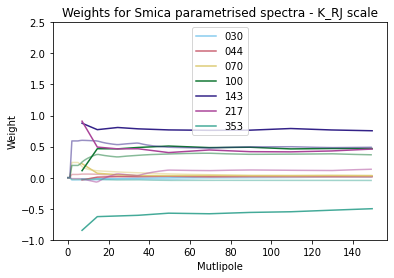

(-0.1, 0.6)

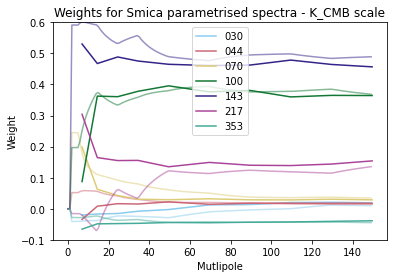

In [44]:
for det in range(0,7):
    plt.plot(np.mean(bins, axis=1), weights_RJ[0,:,det], label=detector[det], color=csu.CB_color_cycle[det])
    plt.plot(smica_W_pol[0,det,:150], color=csu.CB_color_cycle[det], alpha=0.5)

    
plt.legend(loc='upper center')
plt.ylabel('Weight')
plt.xlabel('Mutlipole')
plt.title("Weights for Smica parametrised spectra - K_RJ scale")
plt.ylim((-1,2.5))
plt.show()

for det in range(0,7):
    plt.plot(np.mean(bins, axis=1), weights[0,:,det], label=detector[det], color=csu.CB_color_cycle[det])
    plt.plot(smica_W_pol[0,det,:150], color=csu.CB_color_cycle[det], alpha=0.5)

plt.legend(loc='upper center')
plt.ylabel('Weight')
plt.xlabel('Mutlipole')
plt.title("Weights for Smica parametrised spectra - K_CMB scale")
plt.ylim((-0.1,0.6))

# BACKUP